# Simulation study on multiple regions of chromosome 1 in PAGE AfrAmr data
1. Multiple regions within single causal SNP is simulated.
2. Different hsq in {0.002, 0.005, 0.01, 0.025, 0.05} is simulated.
3. Different metrics, including slope, Pearson's correlation, HET p-value is recorded.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
import admix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import dapgen
from os.path import join
import admix_genet_cor
import itertools
import submitit
from scipy.stats import pearsonr, linregress
from tqdm import tqdm
import string
import scipy

In [2]:
# 1st local ancestry = AFR, 2nd local ancestry = EUR

GENO_DIR = (
    "/u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/01_dataset/out/aframr"
)
pfile = join(GENO_DIR, "imputed/chr1")
df_snp_info = pd.read_csv(pfile + ".snp_info", sep="\t").set_index("SNP")

df_snp_info = df_snp_info[
    df_snp_info.EUR_FREQ.between(0.005, 0.995)
    & df_snp_info.AFR_FREQ.between(0.005, 0.995)
]

In [3]:
def submit_simulate(hsq, causal_snps, out):
    df_rls = []
    for snp in causal_snps:
        df_rls.append(
            admix_genet_cor.simulate_hetero_assoc(pfile=pfile, hsq=hsq, causal_snp=snp)
        )
    df_rls = pd.concat(df_rls)
    df_rls["hsq"] = hsq
    df_rls.to_csv(out, sep="\t")
    return df_rls

In [4]:
hsq_list = [0.002, 0.005, 0.01, 0.025, 0.05]
np.random.seed(42)
df_params = []
for hsq in hsq_list:

    causal_snps = df_snp_info.sample(n=5000).index.values  # sample 5,000 causal SNPs
    causal_snps_list = np.array_split(causal_snps, 160)  # divide into 80 groups
    df_params.append(
        pd.DataFrame(
            [(hsq, snps) for snps in causal_snps_list],
            columns=["hsq", "causal_snps"],
        )
    )
df_params = pd.concat(df_params)
df_params["chunk_i"] = np.arange(len(df_params))
df_params["out"] = df_params.apply(lambda x: f"out/locus/chunk_{x.chunk_i}.tsv", axis=1)

In [ ]:
executor = submitit.SgeExecutor(folder="./submitit-logs")

executor.update_parameters(
    time_min=40,
    memory_g=8,
    queue="highp",
    setup=[
        "export PATH=~/project-pasaniuc/software/miniconda3/bin:$PATH",
        "export PYTHONNOUSERSITE=True",
    ],
)

jobs = executor.map_array(
    submit_simulate, df_params.hsq, df_params.causal_snps, df_params.out
)

In [42]:
df_rls = []
for f in df_params["out"]:
    if os.path.exists(f):
        df_rls.append(pd.read_csv(f, sep="\t"))
df_rls = pd.concat(df_rls).reset_index(drop=True)

df_rls = pd.concat(
    [
        df_rls,
        df_snp_info[["EUR_FREQ", "AFR_FREQ"]]
        .reindex(df_rls.test_snp)
        .reset_index(drop=True),
    ],
    axis=1,
)

# subset hsq
df_rls = df_rls[df_rls.hsq.isin([0.002, 0.005, 0.01])]
df_rls_causal = df_rls[df_rls.test_snp == df_rls.causal_snp].copy()
df_rls_causal["assoc_pval_rank"] = -1
df_rls = pd.concat([df_rls[df_rls.assoc_pval_rank.between(0, 4)], df_rls_causal])
# potential filtering by MAF
# df_rls = df_rls[df_rls.EUR_FREQ.between(0.1, 0.9) & df_rls.AFR_FREQ.between(0.1, 0.9)]
# ** Load old results and create reflection, because in the old results we didn't create randomness of the sign

# df_rls = []
# for f in glob.glob("out/OLD_locus/*.tsv"):
#     df_rls.append(pd.read_csv(f, sep="\t"))
# df_rls = pd.concat(df_rls)

# # create relection
# df_rls2 = df_rls.copy()
# df_rls2[["coef1", "coef2"]] *= -1
# df_rls = pd.concat([df_rls, df_rls2])

In [43]:
def summarize_rls(df_rls):
    # 1st local ancestry = AFR, 2nd local ancestry = EUR

    # *** regress_method can be one of OLS, TLS
    regress_method = lambda x, y: linregress(x=x, y=y)[0]

    # regress_method = lambda x, y: admix_genet_cor.locus.tls(x=x, y=y)[0]
    # regress_method = lambda x, y: admix_genet_cor.locus.orthoregress(x=x, y=y)[0]

    df_rls_grouped = df_rls.groupby(["hsq", "assoc_pval_rank"])

    df_plot = pd.DataFrame(
        {
            "het_inflation": df_rls_grouped.apply(
                lambda x: admix.data.lambda_gc(x["het_pval"])
            ),  # HET p-value
            "het_fpr": df_rls_grouped.apply(lambda x: np.mean(x["het_pval"] < 0.05)),
            "pearsonr": df_rls_grouped.apply(
                lambda x: pearsonr(x["coef1"], x["coef2"])[0]
            ),  # Pearson's correlation between two coefficents
            "deming_eur~afr": df_rls_grouped.apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x["coef1"], y=x["coef2"], sx=x["se1"], sy=x["se2"]
                )[0]
            ),  # EUR ~ AFR
            "deming_afr~eur": df_rls_grouped.apply(
                lambda x: admix_genet_cor.locus.deming_regression(
                    x=x["coef2"], y=x["coef1"], sx=x["se2"], sy=x["se1"]
                )[0]
            ),  # AFR ~ EUR
            "ols_eur~afr": df_rls_grouped.apply(
                lambda x: linregress(x=x["coef1"], y=x["coef2"])[0]
            ),
            "ols_afr~eur": df_rls_grouped.apply(
                lambda x: linregress(x=x["coef2"], y=x["coef1"])[0]
            ),
            "causal_prob": df_rls_grouped.apply(
                lambda x: np.mean(x["test_snp"] == x["causal_snp"])
            ),  # probablity of test_snp is causal_snp
        }
    )

    df_plot = df_plot.reset_index(drop=False)
    return df_plot

In [45]:
# point estimate
df_plot = summarize_rls(df_rls).set_index(["hsq", "assoc_pval_rank"])

# standard error
n_bootstrap = 49
df_plot_se = []

for i in tqdm(range(n_bootstrap)):
    df_tmp = (
        summarize_rls(df_rls.sample(len(df_rls), replace=True))
        .set_index(["hsq", "assoc_pval_rank"])
        .reindex(df_plot.index)
    )
    df_plot_se.append(df_tmp)

df_plot_se = pd.DataFrame(
    np.std(df_plot_se, axis=0),
    index=df_plot.index,
    columns=df_plot.columns,
)
df_plot = df_plot.reset_index()
df_plot_se = df_plot_se.reset_index()

100%|██████████| 49/49 [00:33<00:00,  1.46it/s]


In [46]:
(
    df_plot.set_index(["hsq", "assoc_pval_rank"]).round(3).astype(str)
    + "±"
    + df_plot_se.set_index(["hsq", "assoc_pval_rank"]).round(3).astype(str)
)

het_inflation      het_fpr     pearsonr deming_eur~afr  \
hsq   assoc_pval_rank                                                          
0.002 -1                0.998±0.029  0.048±0.003   0.89±0.004    1.001±0.004   
       0                0.964±0.026  0.045±0.003  0.894±0.004    0.997±0.005   
       1                1.031±0.031  0.063±0.003   0.87±0.005    1.004±0.005   
       2                1.088±0.035  0.069±0.003  0.864±0.005    1.012±0.005   
       3                 1.121±0.04  0.073±0.003  0.858±0.005    1.021±0.005   
       4                1.148±0.052  0.074±0.004  0.851±0.005    1.022±0.006   
0.005 -1                0.968±0.029  0.041±0.003  0.954±0.002    1.001±0.003   
       0                0.963±0.028   0.04±0.003  0.956±0.002      1.0±0.003   
       1                1.098±0.036  0.065±0.003  0.932±0.003    1.008±0.003   
       2                1.197±0.041  0.083±0.004  0.924±0.003    1.014±0.004   
       3                 1.254±0.03  0.095±0.005  0.918±0.004    1.022±0.004   
       4                1.249±0.039  0.098±0.004  0.918±0.004    1.031±0.004   
0.010 -1                 0.982±0.04  0.043±0.003  0.977±0.001      1.0±0.002   
       0                0.971±0.035  0.045±0.004  0.976±0.001      1.0±0.002   
       1                1.124±0.045  0.084±0.004  0.956±0.003    1.008±0.003   
       2                1.214±0.039  0.106±0.004  0.946±0.004    1.014±0.003   
       3                1.303±0.043  0.122±0.004  0.938±0.004    1.018±0.003   
       4                1.358±0.041  0.136±0.005  0.931±0.003    1.025±0.004   

                      deming_afr~eur  ols_eur~afr  ols_afr~eur  causal_prob  
hsq   assoc_pval_rank                                                        
0.002 -1                 0.999±0.004   0.967±0.01  0.819±0.008      1.0±0.0  
       0                 1.003±0.005  0.964±0.009   0.828±0.01  0.427±0.008  
       1                 0.996±0.005  0.952±0.009  0.796±0.009  0.151±0.005  
       2                 0.988±0.005   0.958±0.01   0.778±0.01  0.088±0.003  
       3                  0.98±0.005   0.965±0.01   0.762±0.01  0.056±0.004  
       4                 0.978±0.006   0.969±0.01  0.748±0.009  0.046±0.003  
0.005 -1                 0.999±0.003  0.978±0.007  0.931±0.006      1.0±0.0  
       0                   1.0±0.003  0.978±0.007  0.934±0.006   0.51±0.008  
       1                 0.993±0.003   0.97±0.007  0.896±0.007  0.148±0.006  
       2                 0.987±0.004  0.972±0.007  0.879±0.008   0.08±0.004  
       3                 0.978±0.004  0.978±0.007  0.862±0.007  0.051±0.003  
       4                  0.97±0.004   0.99±0.007  0.851±0.008  0.038±0.003  
0.010 -1                   1.0±0.002  0.992±0.004  0.961±0.004      1.0±0.0  
       0                   1.0±0.002  0.992±0.004  0.961±0.004  0.586±0.006  
       1                 0.992±0.003  0.989±0.006  0.925±0.006  0.131±0.005  
       2                 0.986±0.003  0.985±0.006  0.909±0.009  0.068±0.005  
       3                 0.982±0.003  0.989±0.007    0.89±0.01  0.043±0.003  
       4                 0.975±0.003  0.999±0.008  0.868±0.009  0.031±0.003

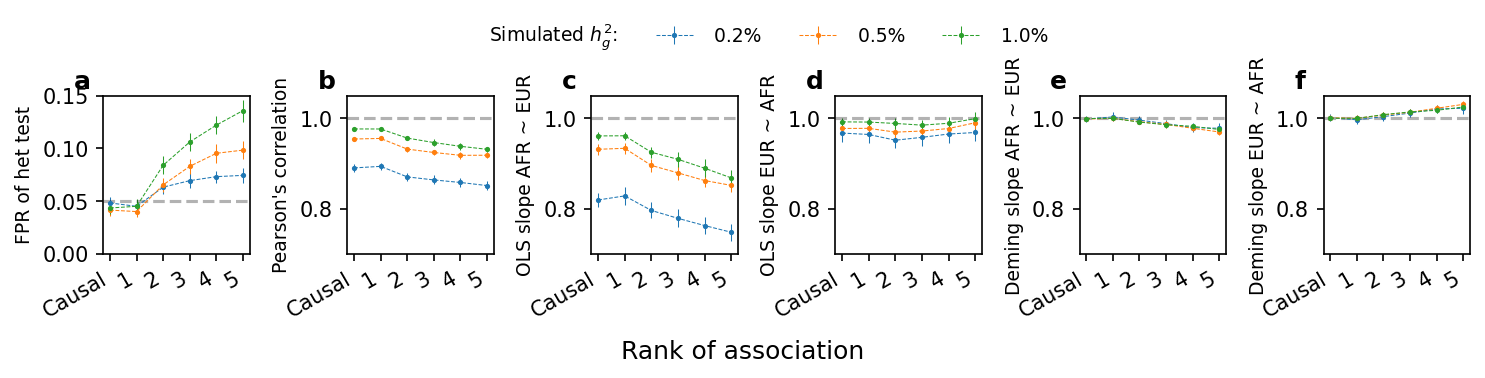

In [53]:
y_var_list = [
    "het_fpr",
    "pearsonr",
    "ols_afr~eur",
    "ols_eur~afr",
    "deming_afr~eur",
    "deming_eur~afr",
]
y_label_list = [
    "FPR of het test",
    "Pearson's correlation",
    "OLS slope AFR ~ EUR",
    "OLS slope EUR ~ AFR",
    "Deming slope AFR ~ EUR",
    "Deming slope EUR ~ AFR",
]
dict_ylim = {
    "het_fpr": [0, 0.15],
    "pearsonr": [0.7, 1.05],
    "ols_afr~eur": [0.7, 1.05],
    "ols_eur~afr": [0.7, 1.05],
    "deming_afr~eur": [0.7, 1.05],
    "deming_eur~afr": [0.7, 1.05],
}
dict_hline = {
    "het_fpr": 0.05,
    "pearsonr": 1.0,
    "ols_afr~eur": 1.0,
    "ols_eur~afr": 1.0,
    "deming_afr~eur": 1.0,
    "deming_eur~afr": 1.0,
}
# "Pearson's correlation" is not plotted because i don't think it makes sense

# makes a 2 x 2 figure
fig, axes = plt.subplots(figsize=(10, 2), ncols=len(y_var_list), nrows=1, dpi=150)
axes = axes.flatten()

for i, (y_var, y_label) in enumerate(zip(y_var_list, y_label_list)):
    ax = axes[i]
    for hsq in df_plot.hsq.unique():
        df_est_tmp = df_plot[df_plot.hsq == hsq]
        df_se_tmp = df_plot_se[df_plot_se.hsq == hsq]
        ax.errorbar(
            df_est_tmp.assoc_pval_rank,
            df_est_tmp[y_var],
            yerr=df_se_tmp[y_var] * 1.96,
            fmt=".--",
            ms=3,
            mew=1,
            label=f"{hsq * 100 : .1f}%",
            linewidth=0.5,
        )

    ax.axhline(y=dict_hline[y_var], color="black", ls="--", alpha=0.3)
    ax.set_xticks(np.arange(-1, 5))
    ax.set_xticklabels(
        ["Causal"] + np.arange(1, 6).astype(str).tolist(), rotation=30, ha="right"
    )
    #     ax.set_xlabel("Rank of association")
    ax.set_ylabel(y_label, fontsize=9)
    ax.set_ylim(dict_ylim[y_var])

    # annotation
    ax.text(
        -0.2,
        1.05,
        string.ascii_lowercase[i],
        transform=ax.transAxes,
        size=12,
        weight="bold",
    )

# trick to put title in the same row
handles, labels = axes[0].get_legend_handles_labels()
ph = [plt.plot([], marker="", ls="")[0]]  # Canvas
handles = ph + handles
labels = ["Simulated $h_g^2$:"] + labels  # Merging labels
fig.legend(
    handles,
    labels,
    ncol=5,
    loc="center",
    bbox_to_anchor=[0.5, 1.02],
    frameon=False,
    fontsize=9,
)

fig.text(
    0.5,
    -0.05,
    "Rank of association",
    fontsize=12,
    ha="center",
)


plt.tight_layout()
plt.savefig("figure1.pdf", bbox_inches="tight")
plt.show()

# Visualize one specific results

In [ ]:
slope, intercept = linregress(x=df_tmp.coef2, y=df_tmp.coef1)[0:2]
print(slope, intercept)

In [ ]:
slope, intercept = admix_genet_cor.locus.deming_regression(
    x=df_tmp.coef2, y=df_tmp.coef1, sx=df_tmp.se2, sy=df_tmp.se1
)
print(slope, intercept)

In [ ]:
df_tmp = df_rls[(df_rls.hsq == 0.002) & (df_rls.assoc_pval_rank == 3)]
print("Simulated $h^2_g = 0.002$, assoc_pval_rank=4")

fig, axes = plt.subplots(figsize=(6, 3.5), dpi=150, ncols=2)

for i, (x, y) in enumerate(
    [[df_tmp.coef1, df_tmp.coef2], [df_tmp.coef2, df_tmp.coef1]]
):
    ax = axes[i]

    ax.scatter(x, y, s=2, alpha=0.3)
    ax.plot([-1, 1], [-1, 1], "k--", label="y=x")

    slope, intercept = linregress(x=x, y=y)[0:2]
    ax.plot(
        [-1, 1],
        [-slope + intercept, slope + intercept],
        "r--",
        label=f"y={slope:.2g}x + {intercept:.2g} (fitted)",
    )
    ax.legend(loc="center", bbox_to_anchor=[0.5, 1.15])

    # 1st local ancestry = AFR, 2nd local ancestry = EUR
    if i == 0:
        xlabel, ylabel = "AFR beta", "EUR beta"
    elif i == 1:
        xlabel, ylabel = "EUR beta", "AFR beta"
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

fig.tight_layout()

# Deprecated: Compare with old results

In [ ]:
assert False

In [ ]:
import glob

In [ ]:
# 1st local ancestry = AFR, 2nd local ancestry = EUR

df_tmp = df_rls_old[(df_rls_old.hsq == 0.01) & (df_rls_old.assoc_pval_rank == 3)]
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
plt.scatter(df_tmp.coef2, df_tmp.coef1, s=2)
ax.plot([-1, 1], [-1, 1], "r--")
print(linregress(x=df_tmp.coef2, y=df_tmp.coef2))